In [1]:
import os
os.chdir('../')
os.getcwd()

'/work'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from tqdm.notebook import tqdm

# 実験コード作成

In [9]:
from sklearn.metrics import mean_squared_error, accuracy_score, auc

In [8]:
from process.preprocess.get_dataset import get_dataset
from process.preprocess.get_set_options import get_options
from process.preprocess.turn_params import turn_params
from process.mainprocess.split_data import split_data
from process.mainprocess.models import DartForDomainAdaptation

In [11]:
class Args():
    def __init__(self, dataset, source, metrics, tune=False):
        self.dataset = dataset
        self.source = source
        self.metrics = metrics
        self.baseline = None
        self.tune = tune
        
CONFIG_DIR_UCI = './configs/experiments_uci.yml'
CONFIG_DIR_WEKA = './configs/experiments_weka.yml'

args_auto_mobile = Args("auto_mobile", "weka", "RMSE", tune=False)
args_autoMPG = Args("autoMPG", "weka", "RMSE", tune=False)
args_concrete = Args("concrete", "weka", "RMSE", tune=False)
args_housing = Args("housing", "weka", "RMSE", tune=False)
args_mushroom = Args("mushroom", "uci", "error rate", tune=False)

In [12]:
def preprocesses(args):
    options = get_options(args)
    # 提案手法のみ実行
    options["experiments"]["methods"] = ["DART for DA"]
    df = get_dataset(options["datasets"])
    if args.tune:
        options = turn_params(options, None, df, is_plot=False)
    return options, df

In [17]:
def return_metrics(y_true, y_pred, metrics):
    if metrics=="MSE":
        return mean_squared_error(y_true, y_pred)
    elif metrics=="RMSE":
        return mean_squared_error(y_true, y_pred)**0.5
    elif metrics=="accuracy":
        return accuracy_score(y_true, y_pred)
    elif metrics=="error rate":
        return 1 - accuracy_score(y_true, y_pred)
    elif metrics=="auc":
        return auc(y_true, y_pred)
    else:
        raise TypeError(f"{metrics} is illegal metrics.")


def _run_model(X_train, y_train, 
                    X_train_target, y_train_target, 
                    X_test, y_test, 
                    domain_col, options, model_name, target_domain):
    
    # 提案手法のみ実行
    if model_name == "DART for DA":
        X_train_source = X_train[domain_col!=target_domain]
        y_train_source = y_train[domain_col!=target_domain]
        model = DartForDomainAdaptation(options, model_name)
        model.fit_source(X_train_source, y_train_source)
        model.fit(X_train_target, y_train_target)
        y_pred = model.predict(X_test)

    metrics = options["experiments"]["metrics"]
    # 落した木の数をカウント
    drop_num = sum(model.model.drop_idx)
    return return_metrics(y_test, y_pred, metrics), drop_num

In [21]:
def experiment_main(options, df, target_domain, exp_round):

    X_train, y_train, X_train_target, y_train_target, X_test, y_test, domain_col = \
        split_data(options, df, target_domain, exp_round)


    result = {}

    for model_name in options["experiments"]["methods"]:
        result[model_name], drop_num = _run_model(
            X_train, y_train, X_train_target, y_train_target, X_test, y_test, 
            domain_col, options, model_name, target_domain
        )

    return result, drop_num

def mainprocess(options, df):

    # 各パラメータを取り出す
    cols = ["target_domain", "drop_num", "metrics"]
    domains = df[options['datasets']['split_feature']].unique()
    n_domains = len(domains)
    n_experiments = options['experiments']['n_experiments']

    # tqdm設定
    bar = tqdm(total=n_domains*n_experiments)
    bar.set_description('Experiments progress')

    # 実験
    results = pd.DataFrame(columns=cols, index=range(n_domains*n_experiments), dtype=float)
    for domain_num, target_domain in enumerate(domains):
        for exp_round in range(n_experiments):
            idx = domain_num*n_experiments + exp_round
            # 実験結果の取得
            result, drop_num = experiment_main(options, df, target_domain, exp_round)
            results.loc[idx, "target_domain"] = target_domain
            results.loc[idx, "drop_num"] = int(drop_num)
            results.loc[idx, "metrics"] = result["DART for DA"]
            bar.update(1)

    return results

In [39]:
def _get_scatterplot(data):
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    sns.scatterplot("drop_num", "metrics", style="target_domain",
                    ax=ax, data=data)
    
    return fig


def postprocesses(options, results):
    fig_scatter =  _get_scatterplot(results)
    
    return fig_scatter

In [40]:
def run(args):
    options, df = preprocesses(args)
    results= mainprocess(options, df)
    fig_scatter = postprocesses(options, results)
    
    return results, fig_scatter

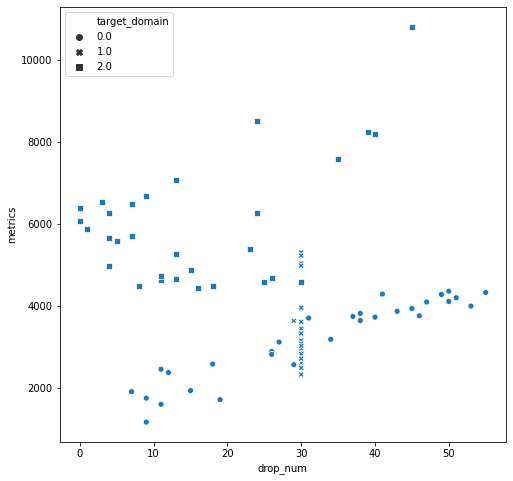

In [44]:
results_auto_mobile, fig_auto_mobile = run(args_auto_mobile)

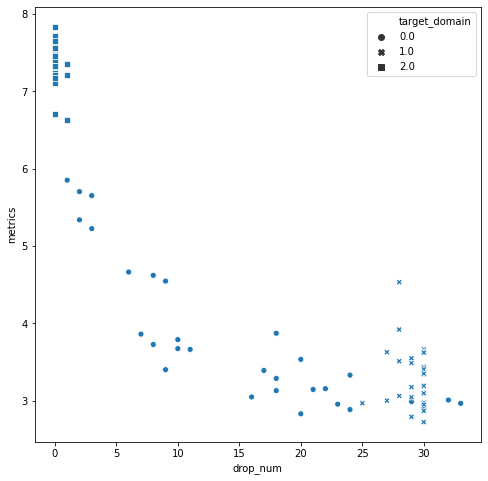

In [45]:
results_autoMPG, fig_autoMPG = run(args_autoMPG)

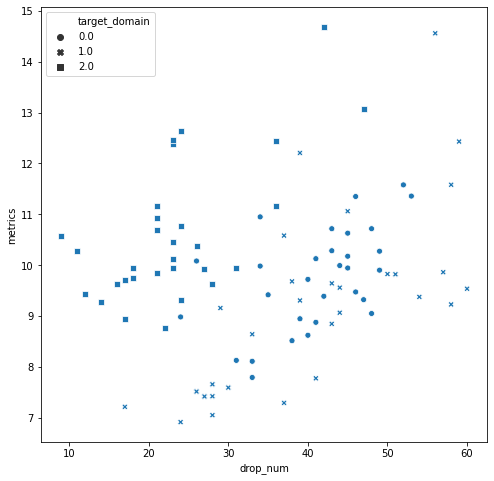

In [42]:
results_concrete, fig_concrete = run(args_concrete)

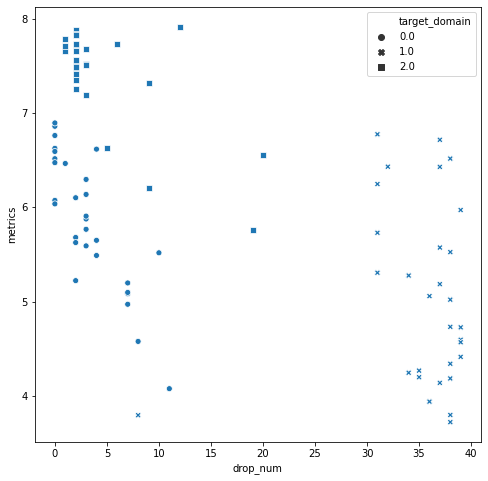

In [46]:
results_housing, fig_housing = run(args_housing)

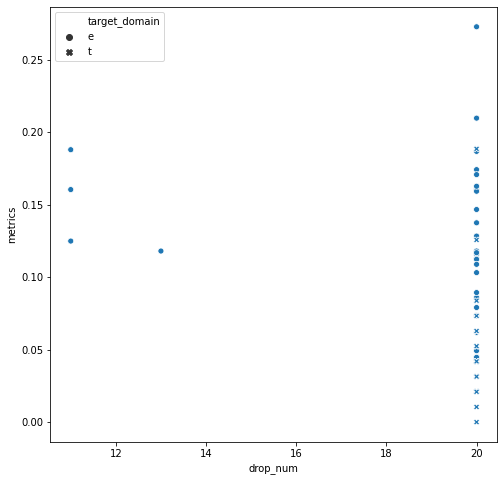

In [43]:
results_mushroom, fig_mushroom = run(args_mushroom)

<AxesSubplot:xlabel='drop_num', ylabel='metrics'>

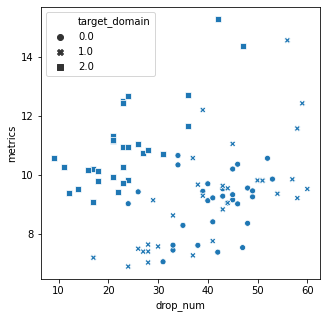

In [38]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.scatterplot("drop_num", "metrics", style="target_domain",
    ax=ax, data=results_concrete
)